## Agent 구축2

### 1.Model 및 Tool 정의

In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI

model = ChatGoogleGenerativeAI(model="gemini-3-flash-preview")

In [2]:
from langchain.tools import tool

@tool
def search_manual(query: str) -> str:
    """
    고객의 질문에 답변하기 위해 참고할만한 규정이나 메뉴얼을 검색할 때 사용하는 도구
    """
    if '비밀번호' in query :
        return '비밀번호 변경은 마이페이지 - 보안 설정에 있음'
    elif '배송' in query :
        return '00택배에서 3일 내 배송 예정임'
    else :
        return '해당 내용 관련 메뉴얼은 찾을 수 없습니다.'

In [3]:
tools = [search_manual]

In [4]:
model_with_tools = model.bind_tools(tools)

### 2. State

In [6]:
from langchain.messages import AnyMessage
from typing_extensions import TypedDict, Annotated
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    next_step: str

### 3.Node 정의

In [26]:
from langchain.messages import SystemMessage

def classify_node(state: AgentState):
    print("\n--- [1] 분류 단계 (LLM 판단) ---")
    last_message = state["messages"][-1]

    prompt = """
    당신은 고객 센터 관리자입니다. 고객의 이메일을 분석해서 다음 단계를 결정하세요.

    1. 단순 문의나 정보 요청이라면 -> 'consultant' 반환
    2. 환불 요청, 불만 제기, 화난 고객이라면 -> 'escalate' 반환

    답변은 오직 단어 하나만 하세요.
    """

    #LLM 호출
    resposne = model.invoke([SystemMessage(content=prompt), last_message])
    raw_content = resposne.content

    if isinstance(raw_content, list):
        # Gemini 등: 리스트로 오는 경우 텍스트 블록만 추출해서 합침
        decision = "".join([block['text'] for block in raw_content if block.get('type') == 'text'])
    else: 
        # OpenAI 등: 문자열로 오는 경우 그대로 사용
        decision = str(raw_content)
    
    # 공백 제거 및 소문자 변환
    decision = decision.strip().lower()
    print(f"  -> LLM 판단 결과: {decision}")

    # 다음 단계(next_step)를 상태에 저장
    if "escalate" in decision:
        return {"next_step": "escalte"}
    else:
        return {"next_step": "consultant"}

In [27]:
def consultant_node(state: AgentState):
    print("\n--- [2-A] 상담 AI 답변 생성 중 ---")
    response = model_with_tools.invoke(state['messages'])
    return {'messages': [response]}

In [28]:
from langchain_core.messages import AIMessage

def escalate_node(state: AgentState):
    return {'messages' : [AIMessage(content='해당 메일은 전문 상담원에게 이관되었습니다.')]}

In [29]:
tools

[StructuredTool(name='search_manual', description='고객의 질문에 답변하기 위해 참고할만한 규정이나 메뉴얼을 검색할 때 사용하는 도구', args_schema=<class 'langchain_core.utils.pydantic.search_manual'>, func=<function search_manual at 0x13827db20>)]

In [30]:
tools_by_name = {tool.name: tool for tool in tools}

In [31]:
tools_by_name

{'search_manual': StructuredTool(name='search_manual', description='고객의 질문에 답변하기 위해 참고할만한 규정이나 메뉴얼을 검색할 때 사용하는 도구', args_schema=<class 'langchain_core.utils.pydantic.search_manual'>, func=<function search_manual at 0x13827db20>)}

In [32]:
from langchain.messages import ToolMessage

def tool_node(state: AgentState):
    print("\n--- [Tool Node] 도구 직접 실행 ---")
    result = []
    # 가장 최근 메시지에서 도구 호출 요청 꺼내기
    last_message = state["messages"][-1]

    for tool_call in last_message.tool_calls:
        # 1. 도구 이름으로 실제 함수 찾기
        tool = tools_by_name[tool_call["name"]]

        # 2. 함수를 실행하여 결과를 얻기
        print(f"   ->실행 중: {tool_call['name']}")
        tool_result = tool.invoke(tool_call["args"])

        # 3. 결과를 ToolMessage 형태로 포장 (tool_call_id 필수!)
        result.append(ToolMessage(content=str(tool_result), tool_call_id=tool_call["id"]))

    # 실행 결과를 대화 기록에 추가
    return {"messages": result}

### 4. 그래프 생성

In [33]:
from langgraph.graph import StateGraph, START, END

agent_builder = StateGraph(AgentState)

agent_builder.add_node('classify_node', classify_node)
agent_builder.add_node('consultant_node', consultant_node)
agent_builder.add_node('escalate_node', escalate_node)
agent_builder.add_node('tool_node', tool_node)

agent_builder.add_edge(START, 'classify_node')

In [34]:
# 라우터 1: 분류 결과에 따른 분기
def route_after_classify(state: AgentState):
    if state['next_step'] == 'escalate' :
        return 'escalate'
    else :
        return 'consultant'

In [35]:
# 라우터 2: 도구 사용 여부 판단
def should_continue(state: AgentState):
    last_message = state['messages'][-1]

    # LLM이 도구 호출(tool_calls)을 포함한 응답을 보낸 경우
    if last_message.tool_calls:
        return "tool_node"
    
    # 도구 호출이 없으면 종료
    return END

In [36]:
# 4. 조건부 엣지 연결
agent_builder.add_conditional_edges(
    'classify_node',
    route_after_classify,
    {
        'escalate' : 'escalate_node',
        'consultant' : 'consultant_node'
    }
)


In [37]:
# 상담 AI 후 도구 사용 여부 판단
agent_builder.add_conditional_edges(
    'consultant_node',
    should_continue,
    ['tool_node', END]
)

In [38]:
# 5. 나머지 엣지 연결
agent_builder.add_edge('tool_node', 'consultant_node')
agent_builder.add_edge('escalate_node', END)

In [39]:
agent = agent_builder.compile()

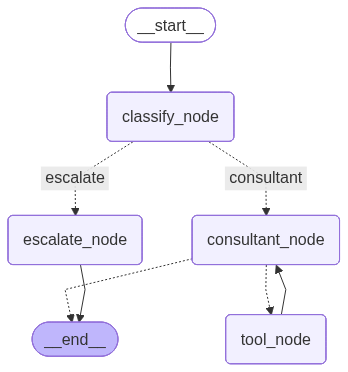

In [40]:
agent

### 실행

In [41]:
from langchain.messages import HumanMessage, SystemMessage

inputs = {"messages" : [HumanMessage(content="비밀번호 변경은 어디서 해?")]}
response = agent.invoke(inputs)


--- [1] 분류 단계 (LLM 판단) ---
  -> LLM 판단 결과: consultant

--- [2-A] 상담 AI 답변 생성 중 ---

--- [Tool Node] 도구 직접 실행 ---
   ->실행 중: search_manual

--- [2-A] 상담 AI 답변 생성 중 ---


ChatGoogleGenerativeAIError: Error calling model 'gemini-3-flash-preview' (RESOURCE_EXHAUSTED): 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 20, model: gemini-3-flash\nPlease retry in 32.975965533s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerDayPerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-3-flash'}, 'quotaValue': '20'}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '32s'}]}}

In [ ]:
response

In [ ]:
response["messages"][-1].content[-1]['text']

In [ ]:
inputs = {"messages": [HumanMessage(content="당장 환불해줘!")]}
response = agent.invoke(inputs)

In [ ]:
response